# Only use competicion data for both fine-tuning and final classification

Data used for fine-tuning and final classification :

* corpus completo 5 temas - 08-sep-2016 - codificacion 5 temas.csv (competition)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
from fastai.text import *
import html
import json

import pandas as pd
import numpy as np
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(52)

In [2]:
DATA_PATH=Path('./DATA/2017')
# DATA_PATH=Path('./data/election_tweets')

WIKILM_PATH=Path('./WIKI_LM/LM')
PRE_FINETUNE_PATH=Path('./FINETUNE/2017/')

TWEETSLM_PATH=Path('./TWEETS_LM/2017')
CLAS_PATH=Path('./TWEETS_CLAS/2017')

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

## Prepare Data

In [3]:
df_trn = pd.read_csv(DATA_PATH/'train.csv', header=None)
df_val = pd.read_csv(DATA_PATH/'validation.csv', header=None)
df_tst = pd.read_csv(DATA_PATH/'test.csv', header=None)
df_gen = pd.read_csv(DATA_PATH/'general.csv', header=None)

In [4]:
tweets = np.concatenate([df_trn, df_val, df_gen])
tweets_tst = np.concatenate([df_tst])
del df_trn, df_val, df_tst, df_gen

tweets[:5]

array([[3,
        '-Me caes muy bien \n-Tienes que jugar más partidas al lol con Russel y conmigo\n-Por qué tan Otako, deja de ser otako\n-Haber si me muero'],
       [0,
        '@myendlesshazza a. que puto mal escribo\n\nb. me sigo surrando help \n\n3. ha quedado raro el "cómetelo" ahí JAJAJAJA'],
       [0,
        '@estherct209 jajajaja la tuya y la d mucha gente seguro!! Pero yo no puedo sin mi melena me muero '],
       [1, 'Quiero mogollón a @AlbaBenito99 pero sobretodo por lo rápido que contesta a los wasaps '],
       [0, 'Vale he visto la tia bebiendose su regla y me hs dado muchs grima ']], dtype=object)

In [5]:
np.random.shuffle(tweets)
tweets[:5]

array([[1,
        '“@rdelvalle: Qué pena que @JuanraLucas no sea Pedro Piqueras. Entonces sería Juan Dramón Lucas #jajaja #socorro #mátenmeYA” Yo el primero :)'],
       [1,
        '“@vvillarroel: RT @jcponline: Deberíamos dejar de ser portavoces del Sur, para ser altavoces del Sur #EncuentroONGD” Me gusta esta idea.'],
       [1, '#ahora_chacon a ganar, a x el futuro; adelante!'],
       [1, 'Buenas noches a tod@s que soñeis como sueña el flamenco'],
       [0,
        'Ahora que se multiplica la corrupción política, concluyamos que Fraga nunca se enriqueció en ninguno de sus muchos cargos.']],
      dtype=object)

In [6]:
def flattern(A):
    'Source: https://stackoverflow.com/a/17867797/7273299'
    
    'Flattens a list of lists and strings into a list.'
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flattern(i))
        else: rt.append(i)
    return rt

def isInt(v):
    'Source: https://stackoverflow.com/a/9859202/7273299'
    
    'Checks if a string is a number.'
    try:     i = int(v)
    except:  return False
    return True

def char_count(word, chars, lbound=2):
    char_count = [word.count(char) for char in chars]
    return all(i >= lbound for i in char_count)

def replace_lol(repl_str, texts):
    for string, chars in repl_str:
        texts = [[[string] if char_count(i, set(chars), 2) else i for i in text.split()] for text in texts]
        texts = np.array([flattern(text) for text in texts])
        texts = np.array([' '.join(text) for text in texts])
    return texts

def preprocess_tweets(tweets):
    """
    twitter specific text processing and shuffle
    """
    # Remove \n
    tweets = np.array([str(i).replace('\n','') for i in tweets])
    tweets = np.array([str(i).replace('&lt;','') for i in tweets])
    tweets = np.array([str(i).replace('&gt;','') for i in tweets])
    
    # Placeholders for hyperlinks and user references
    tweets = [['hyp_link' if i.startswith('http') 
               else 'user_ref' if i.startswith('@')
               else 'hash_tag' if i.startswith('#')
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for integers
    tweets = [[['int_string'] if isInt(i) 
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for slang
    tweets = [[['que'] if i in ['q', 'k', 'qu', 'ke', 'qe'] 
               else ['por'] if i=='x' 
               else ['porque'] if i in ['xq', 'pq', 'porq'] 
               else ['de'] if i=='d' 
               else ['te'] if i=='t'
               else ['también'] if i=='tb'
               else ['Que'] if i in ['Q', 'K', 'Qu','Ke', 'Qe'] 
               else ['Por'] if i=='X'
               else ['Porque'] if i in ['Xq', 'Pq', 'Porq'] 
               else ['De'] if i=='D' 
               else ['Te'] if i=='T'
               else ['También'] if i=='Tb'
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Lol type characters
    repl_str = [('risa_ja','ja'), ('risa_ji','ji'), ('risa_je','je'), ('risa_jo','jo'), ('risa_ju', 'ju'),
               ('risa_ja','aj'), ('risa_ji','ij'), ('risa_ju', 'uj'), ('risa_ja', 'lol')]

    # Adding prefix to lol type characters
    tweets = replace_lol(repl_str, tweets)

    return tweets


In [7]:
tweets[:,1] = preprocess_tweets(tweets[:,1])
tweets_tst[:,1] = preprocess_tweets(tweets_tst[:,1])

In [8]:
tweets[:5]

array([[1,
        '“@rdelvalle: Qué pena que user_ref no sea Pedro Piqueras. Entonces sería Juan Dramón Lucas hash_tag hash_tag hash_tag Yo el primero :)'],
       [1,
        '“@vvillarroel: RT user_ref Deberíamos dejar de ser portavoces del Sur, para ser altavoces del Sur hash_tag Me gusta esta idea.'],
       [1, 'hash_tag a ganar, a por el futuro; adelante!'],
       [1, 'Buenas noches a tod@s que soñeis como sueña el flamenco'],
       [0,
        'Ahora que se multiplica la corrupción política, concluyamos que Fraga nunca se enriqueció en ninguno de sus muchos cargos.']],
      dtype=object)

In [9]:
# POSI_train_docs = [tweets[i] for i in range(len(tweets)) if tweets[i, 0] == 0]
# NEGA_train_docs = [tweets[i] for i in range(len(tweets)) if tweets[i, 0] == 1]
# NEUT_train_docs = [tweets[i] for i in range(len(tweets)) if tweets[i, 0] == 2]
# NONE_train_docs = [tweets[i] for i in range(len(tweets)) if tweets[i, 0] == 3]
# del tweets

# level_train_docs = [POSI_train_docs,NEGA_train_docs,NEUT_train_docs,NONE_train_docs]

# fmt = """Positive Sentences = {:d}
#        \rNegative Sentences = {:d}
#        \rNeutral  Sentences = {:d}
#        \rNone Values        = {:d}"""

# print(fmt.format(len(POSI_train_docs),
#                  len(NEGA_train_docs),
#                  len(NEUT_train_docs),
#                  len(NONE_train_docs)))

# minSentLvl = min(len(POSI_train_docs),len(NEGA_train_docs),len(NEUT_train_docs),len(NONE_train_docs))

# print('Minimum number of sentences per level : ', minSentLvl)

# import random
# tweets_bal = []
# for i in range(len(level_train_docs)):
#     level_per = random.sample(level_train_docs[i],len(level_train_docs[i]))
#     tweets_bal.append(level_per[:minSentLvl])
    
# print("New size of sentences:\n")
# fmt = """Positive Sentences = {:d}
#        \rNegative Sentences = {:d}
#        \rNeutral  Sentences = {:d}
#        \rNone Values        = {:d}"""

# print(fmt.format(len(tweets_bal[0]),
#                  len(tweets_bal[1]),
#                  len(tweets_bal[2]),
#                  len(tweets_bal[3])))

# flat_tweets_bal = [item for sublist in tweets_bal for item in sublist]
# shuf_tweets_bal = random.sample(flat_tweets_bal,len(flat_tweets_bal))

# assert (len(shuf_tweets_bal) == 4 * minSentLvl)
# print("shuf_tweets_bal size = ", len(shuf_tweets_bal))

# shuf_tweets_bal = np.array(shuf_tweets_bal)
# print(shuf_tweets_bal[:5])

In [10]:
col_names = ['label', 'tweet']

In [11]:
tweets_train, tweets_valid, labels_train, labels_valid = train_test_split(
                                                    tweets[:,1], tweets[:,0],
                                                    stratify=tweets[:,0], 
                                                    test_size=0.10)

# tweets_train, tweets_valid, labels_train, labels_valid = train_test_split(
#                                                     shuf_tweets_bal[:,1], shuf_tweets_bal[:,0],
#                                                     stratify=shuf_tweets_bal[:,0], 
#                                                     test_size=0.10)

print('train shapes:', tweets_train.shape, labels_train.shape)
print('valid shapes:', tweets_valid.shape, labels_valid.shape)
print('test shapes:', tweets_tst.shape)

train shapes: (7858,) (7858,)
valid shapes: (874,) (874,)
test shapes: (1899, 2)


In [12]:
df_trn = pd.DataFrame({'tweet':tweets_train, 'label':labels_train}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets_valid, 'label':labels_valid}, columns=col_names)
df_tst = pd.DataFrame({'tweet':tweets_tst[:,1], 'label':tweets_tst[:,0]}, columns=col_names)

In [13]:
print(df_trn['label'].value_counts())
print(df_val['label'].value_counts())
print(df_tst['label'].value_counts())

1    3022
0    2537
3    1514
2     785
Name: label, dtype: int64
1    336
0    282
3    169
2     87
Name: label, dtype: int64
Series([], Name: label, dtype: int64)


In [14]:
def balance_df(df):
    lst = [df]
    max_size = df['label'].value_counts().max()
    for class_index, group in df.groupby('label'):
        lst.append(group.sample(max_size-len(group), replace=True))
    df = pd.concat(lst)
    return df

df_trn = balance_df(df_trn)

print(df_trn['label'].value_counts())
print(df_val['label'].value_counts())
print(df_tst['label'].value_counts())

3    3022
2    3022
1    3022
0    3022
Name: label, dtype: int64
1    336
0    282
3    169
2     87
Name: label, dtype: int64
Series([], Name: label, dtype: int64)


In [15]:
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'validation.csv', header=False, index=False)
df_tst.to_csv(CLAS_PATH/'test.csv', header=False, index=False)
df_trn.shape, df_val.shape
# (CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in LABELS)

((12088, 2), (874, 2))

### Create dataframes for Language Model fine-tuning

In [16]:
tweets_lm = np.concatenate([tweets_train, tweets_valid, tweets_tst[:,1]])
labels_lm = np.concatenate([labels_train, labels_valid, [0]*len(tweets_tst[:,0])])

tweets_train_lm, tweets_valid_lm, labels_train_lm, labels_valid_lm = train_test_split(
                                                    tweets_lm, labels_lm,
                                                    stratify=labels_lm, 
                                                    test_size=0.10)

In [17]:
df_trn = pd.DataFrame({'tweet':tweets_train_lm, 'label':[0]*len(tweets_train_lm)}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets_valid_lm, 'label':[0]*len(tweets_valid_lm)}, columns=col_names)

In [18]:
df_trn.to_csv(TWEETSLM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(TWEETSLM_PATH/'validation.csv', header=False, index=False)

In [19]:
df_trn.shape, df_val.shape

((9567, 2), (1064, 2))

## Tokenize and Standarize General Tokens


In [20]:
chunksize=24000

re1 = re.compile(r'  +')

In [21]:
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
#     print(df)
    for i, r in enumerate(df):
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [22]:
df_trn = pd.read_csv(TWEETSLM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(TWEETSLM_PATH/'validation.csv', header=None, chunksize=chunksize)

In [23]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [24]:
len(tok_trn),len(trn_labels), len(tok_val), len(val_labels)

(9567, 9567, 1064, 1064)

In [25]:
print(tok_trn[:2])

[['\n', 'xbos', 'volviendo', 'a', 'la', 'facultad', 'para', 'escuchar', 'a', 'user_ref', 'en', 'el', 'foro', 'empresas', 'de', 'comunicación', '.', 'por', 'la', 'complutense', 'no', 'pasa', 'el', 'tiempo', '!', 'hash_tag'], ['\n', 'xbos', 'user_ref', 'nos', 'vas', 'a', 'matar', 'a', 'todos', 'y', 'eso', 'no', 'da', 'elo']]


In [26]:
(TWEETSLM_PATH/'tmp').mkdir(exist_ok=True)

In [27]:
np.save(TWEETSLM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(TWEETSLM_PATH/'tmp'/'tok_val.npy', tok_val)

In [28]:
tok_trn = np.load(TWEETSLM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(TWEETSLM_PATH/'tmp'/'tok_val.npy')

In [29]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(20)

[('\n', 9567),
 ('xbos', 9567),
 ('de', 6885),
 ('user_ref', 5661),
 ('.', 4951),
 (',', 4461),
 ('que', 4327),
 ('la', 4282),
 ('el', 3906),
 ('en', 3603),
 ('a', 3519),
 ('y', 3418),
 ('!', 2872),
 ('hyp_link', 2378),
 ('no', 2131),
 ('"', 1763),
 ('hash_tag', 1754),
 ('t_up', 1703),
 ('es', 1575),
 ('los', 1561)]

In [30]:
max_vocab = 60000
min_freq = 1

In [31]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

7964

In [32]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [33]:
np.save(TWEETSLM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(TWEETSLM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'wb'))

## Load Encoder Weights for Language Model

In [34]:
BACKBONE_MODEL = PRE_FINETUNE_PATH/'models/lm1_wgts.h5'

In [35]:
wgts = torch.load(BACKBONE_MODEL, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [36]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [37]:
itos2 = pickle.load((PRE_FINETUNE_PATH/'tmp'/'itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [38]:
em_sz,nh,nl = 400,1150,3

In [39]:
trn_lm = np.load(TWEETSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TWEETSLM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'rb'))

In [40]:
vs=len(itos)
vs,len(trn_lm)

(7964, 9567)

In [41]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
n_replaced_vocab = 0

for i,w in enumerate(itos):
    r = stoi2[w]
    if r>=0 :
        new_w[i] = enc_wgts[r]
        n_replaced_vocab +=1
    else:
        new_w[i] = row_m

print(f'Reuse {n_replaced_vocab} word embeddings from fine-tuning')
print(f'{vs-n_replaced_vocab} where not in vocab from fine-tuning')

Reuse 6606 word embeddings from fine-tuning
1358 where not in vocab from fine-tuning


"We now overwrite the weights into the wgts odict. The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying."

In [42]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model Finetuning

In [43]:
wd=1e-7
bptt=70
bs=32
em_sz,nh,nl = 400,1150,3
opt_fn = partial(optim.SGD, momentum=0.9)

In [44]:
trn_lm = np.load(TWEETSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TWEETSLM_PATH/'tmp'/'val_ids.npy')
trn_lm = np.concatenate(trn_lm)
val_lm = np.concatenate(val_lm)

In [45]:
itos = pickle.load(open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'rb'))
vs = len(itos)

trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs, bptt)
md = LanguageModelData(TWEETSLM_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [46]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
# drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])

In [47]:
learn = md.get_model(opt_fn, em_sz, nh, nl, dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learn.metrics = [accuracy]
learn.unfreeze()

In [48]:
learn.model.load_state_dict(wgts)

In [61]:
learn.lr_find2(start_lr=2e-3,end_lr=2e-2, num_it=300)

 49%|████▉     | 42/86 [00:17<00:18,  2.37it/s, loss=3.84]

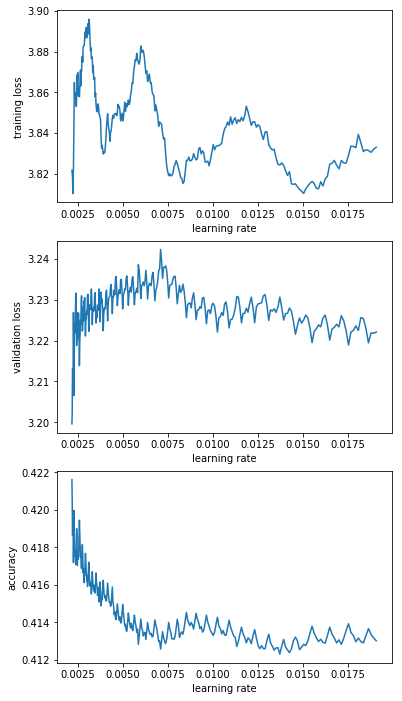

In [62]:
learn.sched.plot()

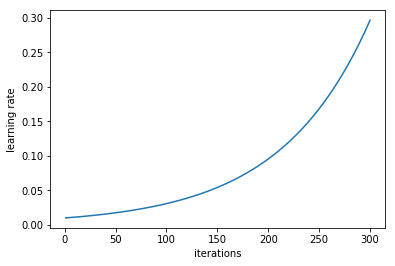

In [54]:
learn.sched.plot_lr()

In [55]:
lr= 1e-2
lrs = lr

In [56]:
learn.clip=0.12

In [57]:
learn.fit(lr, 2, cycle_len=10, use_clr_beta=(10,33,0.95,0.85), best_save_name='lm1_wgts')

epoch      trn_loss   val_loss   accuracy   
    0      3.740196   3.117828   0.434748  
    1      3.738835   3.1316     0.430388  
    2      3.727151   3.118939   0.431721  
    3      3.711862   3.137398   0.428202  
    4      3.727359   3.134955   0.427651  
    5      3.699224   3.135484   0.427279  
    6      3.702072   3.119452   0.429377  
    7      3.690165   3.122864   0.42879   
    8      3.692289   3.131219   0.427632  
    9      3.690742   3.135685   0.426693  
    10     3.693522   3.118488   0.42963   
    11     3.698934   3.119065   0.429348  
    12     3.682251   3.138954   0.426145  
    13     3.686714   3.118115   0.42839   
    14     3.695753   3.133297   0.42538   
    15     3.674485   3.132088   0.425417  
    16     3.67893    3.138857   0.424387  
    17     3.668071   3.118761   0.42584   
    18     3.666912   3.138096   0.424092  
    19     3.675803   3.135556   0.42443   


[array([3.13556]), 0.424429861229176]

In [58]:
learn.load('lm1_wgts')
learn.save_encoder('lm1_enc')

## Classifier tokens

In [63]:
chunksize=24000

re1 = re.compile(r'  +')

In [64]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'validation.csv', header=None, chunksize=chunksize)
df_tst = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [65]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)
tok_tst, tst_labels = get_all(df_tst, 1)

In [66]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

In [67]:
np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)
np.save(CLAS_PATH/'tmp'/'tok_tst.npy', tok_tst)

In [68]:
np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)
# np.save(CLAS_PATH/'tmp'/'tst_labels.npy', tst_labels)

# df = pd.read_csv(CLAS_PATH/'test_labels.csv')
# df['label']=df['label'].replace(['N','P','NEU','NONE'],[0,1,2,3])
# np.save(CLAS_PATH/'tmp'/'tst_labels.npy', df['label'].values)

In [69]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')
tok_tst = np.load(CLAS_PATH/'tmp'/'tok_tst.npy')

In [70]:
itos = pickle.load((TWEETSLM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

7964

In [71]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
tst_clas = np.array([[stoi[o] for o in p] for p in tok_tst])

In [72]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)
np.save(CLAS_PATH/'tmp'/'tst_ids.npy', tst_clas)

## Classifier

In [73]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [74]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [75]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 96

In [76]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1
print(c)

4


In the classifier, unlike LM, we need to read a tweet at a time. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie tweets, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [77]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(TWEETSLM_PATH, trn_dl, val_dl, test_dl=val_dl)

In [78]:
#dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.8
dps = np.array([0.4,0.5,0.05,0.3,0.4])

In [79]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1, layers=[em_sz*3, 50, c], drops=[dps[4], 0.1], dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [80]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [81]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]

In [82]:
# wd = 1e-7
learn.load_encoder('lm1_enc')

In [83]:
learn.freeze_to(-1)

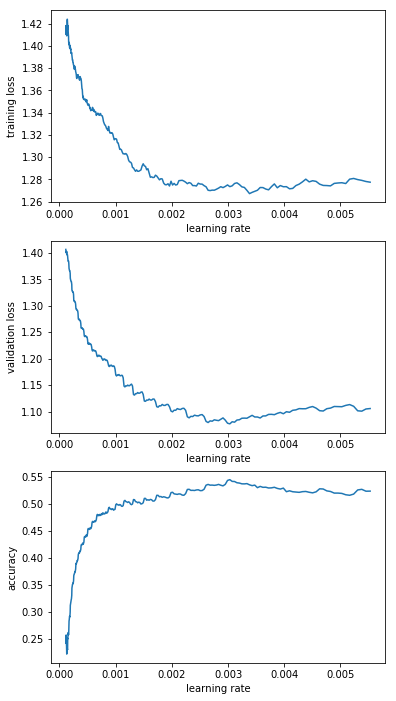

In [84]:
learn.lr_find2(start_lr=1e-4,end_lr=6e-3, num_it=300)
learn.sched.plot()

In [85]:
lr= 10e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [86]:
learn.fit(lrs, 5, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7), best_save_name='clas2_0')

epoch      trn_loss   val_loss   accuracy   
    0      1.26895    1.117293   0.516538  
    1      1.255447   1.122382   0.500296  
    2      1.241682   1.121301   0.488004  
    3      1.215888   1.091689   0.522413  
    4      1.219216   1.088975   0.523598  


[array([1.08898]), 0.5235979496302763]

In [87]:
learn.load('clas2_0')

In [88]:
learn.freeze_to(-2)

In [90]:
learn.fit(lrs, 10, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7),  best_save_name='clas2_1')

epoch      trn_loss   val_loss   accuracy   
    0      1.22504    1.090646   0.521771  
    1      1.21566    1.076583   0.527696  
    2      1.198626   1.059964   0.55238   
    3      1.179799   1.048131   0.538013  
    4      1.16534    1.048115   0.530312  
    5      1.177963   1.052732   0.515946  
    6      1.15447    1.058791   0.503604  
    7      1.152085   1.058591   0.519303  
    8      1.1433     1.040922   0.52582   
    9      1.136928   1.041356   0.535101  


[array([1.04136]), 0.5351007048270149]

In [94]:
learn.load('clas2_1')

In [95]:
learn.unfreeze()

In [96]:
learn.fit(lr, 2, cycle_len=5, use_clr_beta=(32,10,0.8,0.7), best_save_name='final')

epoch      trn_loss   val_loss   accuracy   
    0      1.134763   1.014696   0.57341   
    1      1.065873   0.99393    0.591331  
    2      0.923502   0.98386    0.595577  
    3      0.731603   0.997331   0.609449  
    4      0.614749   0.997021   0.620014  
    5      0.575847   1.060585   0.632356  
    6      0.6229     1.071101   0.62342   
    7      0.56397    1.098866   0.637589  
    8      0.402108   1.204659   0.639662  
    9      0.301027   1.23535    0.643562  


[array([1.23535]), 0.6435623976856611]

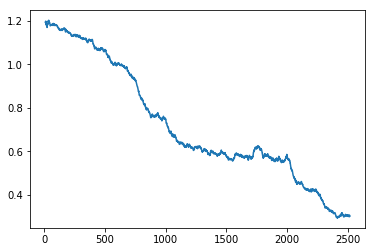

In [97]:
learn.load('final')
learn.sched.plot_loss()

## Model Evaluation

In [93]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [94]:
bs = 256
bptt,em_sz,nh,nl = 70,400,1150,3

tst_sent = np.load(CLAS_PATH/'tmp/tst_ids.npy')
tst_lbls = np.load(CLAS_PATH/'tmp/tst_labels.npy').flatten()
# tst_lbls -= tst_lbls.min()
c=4 #int(tst_lbls.max())+1
tst_ds = TextDataset(tst_sent, tst_lbls)
tst_samp = SortSampler(tst_sent, key=lambda x: len(tst_sent[x]))
tst_lbls_sampled = tst_lbls[list(tst_samp)]
tst_dl = DataLoader(tst_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=tst_samp)
md = ModelData(TWEETSLM_PATH, None, tst_dl)
itos = pickle.load(open(TWEETSLM_PATH/'tmp/itos.pkl', 'rb'))
vs = len(itos)

F1(macro) =  0.4322428043340978
Accuracy  =  0.5365982095839916


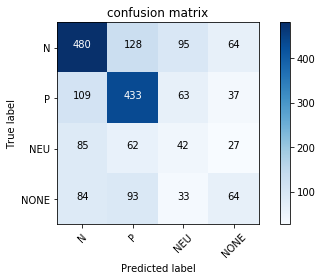

In [95]:
    
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1, layers=[em_sz*3, 50, c], drops=[0., 0.])

learn = RNN_Learner(md, TextModel(to_gpu(m)))
learn.load_encoder('lm1_enc')
learn.load('final')
predictions = np.argmax(learn.predict(), axis=1)

f1 = f1_score(tst_lbls_sampled, predictions, average='macro')
print('F1(macro) = ', f1)

acc = (tst_lbls_sampled == predictions).mean()
print('Accuracy  = ', acc)


cnf_matrix = confusion_matrix(tst_lbls_sampled, predictions)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['N', 'P', 'NEU', 'NONE'], title='confusion matrix')
plt.show()

In [131]:
def getLabel(num):
    if num == 0:
        return 'N'
    elif num == 1:
        return 'P'
    elif num == 2:
        return 'NEU'
    elif num == 3:
        return 'NONE'

In [132]:
import xml.etree.ElementTree as ET

def putTestValue(xmlFIle, out):
    tree = ET.parse(xmlFIle)
    root = tree.getroot()

    tweets = []
    file = open(out,"w") 
    print(file)
    print(len(predictions))
    for i,tweet in enumerate(root.iter('tweet')): 
        val = getLabel(predictions[list(tst_samp).index(i)])
        ID = tweet.find('tweetid').text
        #print(ID)
        file.write(ID + "\t" + val + "\n")
    file.close() 

In [133]:
DATA_PATH = Path('D:/Maestria/NLP/AdvacedSentimentAnalysis/database/')
putTestValue(DATA_PATH/"TASS/TASS2018/task1-Test.xml", TWEETSLM_PATH/"output_ulmfit_2018.txt")

<_io.TextIOWrapper name='TWEETS_LM\\2017\\output_ulmfit_2018.txt' mode='w' encoding='cp1252'>
1899


In [134]:
print(TWEETSLM_PATH/"output_ulmfit_2018.txt")

TWEETS_LM\2017\output_ulmfit_2018.txt
